In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood,OnOffSVGPMC 
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow import conditionals

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

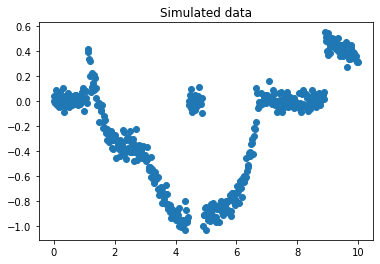

In [3]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

In [4]:
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)

kg = gpf.kernels.RBF(variance=5, lengthscales=2)

# initialise equally spaced inducing point locations
Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)
Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1)

In [5]:
# model definition
m = OnOffSVGPMC(Xtrain, Ytrain
              ,kernf=kf,kerng=kg
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,Zg = Zg, samples=100
             )

# make variance trainable
m.likelihood.variance.assign(0.01)
from gpflow import set_trainable
set_trainable(m.likelihood.variance, True)

In [6]:
N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)


In [7]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
#logf = run_adam(m, 10)

In [8]:
%%time
logf = run_adam(m, 8000)

CPU times: user 51.5 s, sys: 17.1 s, total: 1min 8s
Wall time: 16.8 s


In [9]:
m.samples

100

In [10]:
logf[-1]

150.81998

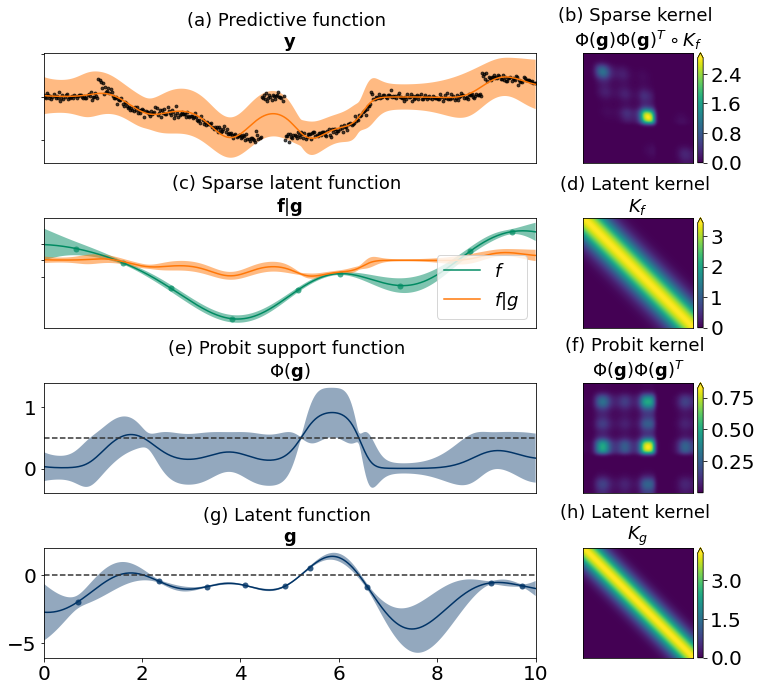

In [11]:

PlotOnOff1D(m)